In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder
import gensim
import numpy as np
import matplotlib.pyplot as plt


EVENT_TEMPLATE_COLUMNS = ['EventTemplate{}'.format(i) for i in range(1, 6)]
NEXT_EVENT_TEMPLATE_COLUMN = 'Next_EventTemplate'

# 1. 加载LDA模型
lda_model_path = r'E:\Code for Project2024\lda_model\model'
lda_model = gensim.models.LdaModel.load(lda_model_path)
n_topics = lda_model.num_topics

# 2. 定义LSTM网络
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden=None):
        if hidden is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
            hidden = (h0, c0)
        out, _ = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])
        return out

In [2]:
# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("将在"+ str(device) +"上训练模型")

# 初始化LSTM模型
model = LSTMNet(input_dim=n_topics, hidden_dim=5, num_layers=3, output_dim=n_topics).to(device)
# 初始化模型参数
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

# 3. 数据处理
csv_file_path = r'E:\Code for Project2024\Data_for_Train\L1\L1 train_dataset.csv'
df = pd.read_csv(csv_file_path)

# 生成每个EventTemplate的LDA概率分布
def get_lda_vector(lda_model, event_templates):
    # 转换event_templates为适合LDA模型的输入形式
    # 假设event_templates已经是预处理过的数据，每个EventTemplate是一个字符串
    corpus = [lda_model.id2word.doc2bow(event.split()) for event in event_templates]
    lda_vectors = [lda_model[doc] for doc in corpus]
    # 转换为密集的独热码形式
    lda_vectors_dense = np.zeros((len(lda_vectors), n_topics))
    for i, doc in enumerate(lda_vectors):
        for topic, prob in doc:
            lda_vectors_dense[i, topic] = prob
    return lda_vectors_dense

# 获取数据集中所有EventTemplate和Next_EventTemplate的LDA概率分布
event_lda_vectors = get_lda_vector(lda_model, df[EVENT_TEMPLATE_COLUMNS].values.flatten())
next_event_lda_vectors = get_lda_vector(lda_model, df[NEXT_EVENT_TEMPLATE_COLUMN].values)

# 将Next_EventTemplate的LDA概率分布转换为独热码
encoder = OneHotEncoder()
next_event_onehot = encoder.fit_transform(next_event_lda_vectors.argmax(axis=1).reshape(-1, 1))


# 转换为Tensor
event_lda_tensors = torch.tensor(event_lda_vectors, dtype=torch.float).view(len(df), -1, n_topics)
next_event_onehot_tensors = torch.tensor(next_event_onehot.toarray(), dtype=torch.float)

将在cuda上训练模型


In [3]:
# 获取Next_EventTemplate的类别索引
next_event_indices = next_event_lda_vectors.argmax(axis=1)
# 创建序列和标签，确保每个序列对应于同一个ExtractedBlockId
grouped = df.groupby('ExtractedBlockId')
sequences = []
window_size = 5  
for name, group in grouped:
    # 假设group是按顺序排列的
    event_templates = group[EVENT_TEMPLATE_COLUMNS].apply(lambda x: ' '.join(x), axis=1).tolist()
    next_event_templates = group[NEXT_EVENT_TEMPLATE_COLUMN].tolist()
    event_lda_vectors = get_lda_vector(lda_model, event_templates)
    next_event_lda_vectors = get_lda_vector(lda_model, next_event_templates)
    
    # 转换Next_EventTemplate的LDA概率分布为独热码
    next_event_onehot = encoder.transform(next_event_lda_vectors.argmax(axis=1).reshape(-1, 1))
    
    for i in range(len(group) - window_size):
        seq = event_lda_vectors[i:i+window_size]  # 提取当前窗口的事件序列
        label_idx = next_event_indices[i+window_size]  # 获取当前窗口后的下一个事件的索引
        sequences.append((torch.tensor(seq, dtype=torch.float), label_idx)) 

# 创建DataLoader
batch_size = 5000
train_loader = DataLoader(sequences, batch_size=batch_size, shuffle=True)

# 4. 训练神经网络
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

epochs = 300
losses = [] 

for epoch in range(epochs):
    total_loss = 0
    for seq, labels in train_loader:
        optimizer.zero_grad()
        seq, labels = seq.to(device), labels.to(device)
    
        # 预测模型输出
        y_pred = model(seq)

        # 将独热编码的标签转换为类别索引
        # 只在labels是二维的情况下使用torch.argmax
        if len(labels.size()) > 1 and labels.size(1) > 1:
            labels = torch.argmax(labels, dim=1)
    
        # 确保labels是一维的
        labels = labels.squeeze()

        # 如果labels的数据类型不是long，将其转换为long
        if labels.dtype != torch.long:
            labels = labels.long()

    # 计算损失并进行反向传播
    loss = criterion(y_pred, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    total_loss += loss.item()
    average_loss = total_loss / len(train_loader)
    losses.append(average_loss)
    print(f'Epoch {epoch} Loss: {average_loss}')

Epoch 0 Loss: 0.7868083715438843
Epoch 1 Loss: 0.7846289873123169
Epoch 2 Loss: 0.7864183187484741
Epoch 3 Loss: 0.7860626578330994
Epoch 4 Loss: 0.7822093963623047
Epoch 5 Loss: 0.7811114192008972
Epoch 6 Loss: 0.7816799283027649
Epoch 7 Loss: 0.7818443179130554
Epoch 8 Loss: 0.7794978618621826
Epoch 9 Loss: 0.7782331705093384
Epoch 10 Loss: 0.7791555523872375
Epoch 11 Loss: 0.7786418199539185
Epoch 12 Loss: 0.7771498560905457
Epoch 13 Loss: 0.774644136428833
Epoch 14 Loss: 0.7754721641540527
Epoch 15 Loss: 0.7746158838272095
Epoch 16 Loss: 0.7733925580978394
Epoch 17 Loss: 0.7754765748977661
Epoch 18 Loss: 0.7706095576286316
Epoch 19 Loss: 0.7700554132461548
Epoch 20 Loss: 0.7699564099311829
Epoch 21 Loss: 0.7675901055335999
Epoch 22 Loss: 0.7697269916534424
Epoch 23 Loss: 0.7659888863563538
Epoch 24 Loss: 0.7678825855255127
Epoch 25 Loss: 0.7686530351638794
Epoch 26 Loss: 0.7652309536933899
Epoch 27 Loss: 0.7643529176712036
Epoch 28 Loss: 0.7633288502693176
Epoch 29 Loss: 0.76256924

Epoch 240 Loss: 0.4551115930080414
Epoch 241 Loss: 0.4461961090564728
Epoch 242 Loss: 0.44606974720954895
Epoch 243 Loss: 0.4429314434528351
Epoch 244 Loss: 0.4356372058391571
Epoch 245 Loss: 0.44533923268318176
Epoch 246 Loss: 0.44405215978622437
Epoch 247 Loss: 0.44073131680488586
Epoch 248 Loss: 0.4460175037384033
Epoch 249 Loss: 0.4395414888858795
Epoch 250 Loss: 0.43574395775794983
Epoch 251 Loss: 0.44178062677383423
Epoch 252 Loss: 0.4463494122028351
Epoch 253 Loss: 0.43623510003089905
Epoch 254 Loss: 0.43563714623451233
Epoch 255 Loss: 0.45283186435699463
Epoch 256 Loss: 0.4378776252269745
Epoch 257 Loss: 0.43564853072166443
Epoch 258 Loss: 0.4387126863002777
Epoch 259 Loss: 0.43132948875427246
Epoch 260 Loss: 0.4453486204147339
Epoch 261 Loss: 0.4401428997516632
Epoch 262 Loss: 0.4373560845851898
Epoch 263 Loss: 0.4372749626636505
Epoch 264 Loss: 0.4388624429702759
Epoch 265 Loss: 0.4327280521392822
Epoch 266 Loss: 0.4342804551124573
Epoch 267 Loss: 0.4299357831478119
Epoch 268

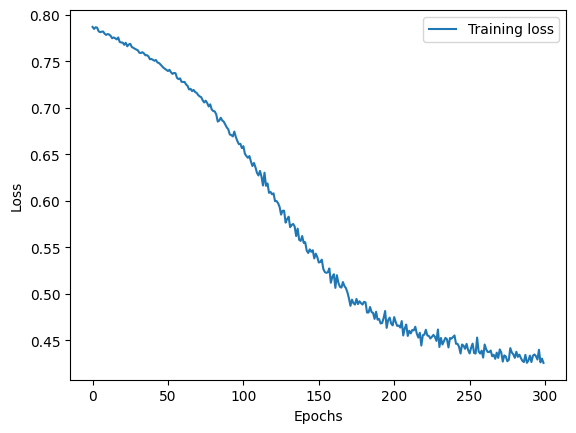

Model saved to E:\Code for Project2024\LSTM_Model\LSTM_model.pth


In [4]:
# 绘制损失图
plt.plot(losses, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 保存模型
model_save_path = r'E:\Code for Project2024\LSTM_Model\LSTM_model.pth' 
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')